# Using Machine Learning To Improve Count-Min Sketches

In [156]:
from sklearn.utils import murmurhash3_32
import random
import sys

random.seed(13)

def h(x, seed, R):
    return murmurhash3_32(key=x, seed=seed) % R

class CountMinSketch:
  def __init__(self, d: int, R: int):
    self.d = d
    self.R = R
    self.array = []

    for _i in range(d):
      self.array.append([0] * R)

  def insert(self, token: str):
    for i in range(self.d):
      hash = h(token, i, self.R)
      self.array[i][hash] += 1

  def query(self, token: str):
    res = []
    for i in range(self.d):
      hash = h(token, i, self.R)
      res.append(self.array[i][hash])
    return min(res)
  
  def get_memory_usage(self):
    memory = sys.getsizeof(self)
    for subarray in self.array:
      memory += sys.getsizeof(subarray)
    return memory

## Oracle Architecture

In [157]:
from collections import defaultdict

from abc import ABC, abstractmethod 
  
class Oracle(ABC): 
  
    @abstractmethod
    def predict_heavy_hitter(self, token): 
        pass

    @abstractmethod
    def get_memory_usage(self): 
        pass

class CountMinSketchWithOracle(CountMinSketch):

  def __init__(self, d: int, R: int, oracle: Oracle):
    super().__init__(d, R)
    self.oracle = oracle
    self.heavy_hitter_counts = defaultdict(int)

  def insert(self, token: str):
    if token in self.heavy_hitter_counts or self.oracle.predict_heavy_hitter(token) == 1:
      self.heavy_hitter_counts[token] += 1
    else:
      super().insert(token)
  
  def fast_insert(self, tokens, is_heavy_hitter):
    for i in range(len(tokens)):
      if is_heavy_hitter[i] == 1:
        self.heavy_hitter_counts[tokens[i]] += 1
      else:
        super().insert(tokens[i])

  def query(self, token: str):
    if token in self.heavy_hitter_counts:
      return self.heavy_hitter_counts[token]
    else:
      return super().query(token)
    
  def get_memory_usage(self):
    return super().get_memory_usage() + self.oracle.get_memory_usage() + sys.getsizeof(self.heavy_hitter_counts)

In [158]:
import pandas as pd

queries = []
for i in range(1, 2):
    data = pd.read_csv('data/aol/user-ct-test-collection-0' + str(i) + '.txt', sep="\t")
    queries.extend(data.Query.dropna())

In [159]:
from collections import Counter 

tokens_freq = Counter(queries)

In [160]:
print(len(tokens_freq))

1216652


In [161]:
common_tokens = tokens_freq.most_common(1000)

In [162]:
HEAVY_HITTER_THRESHOLD = 150
D = 4
R_range = range(17, 22)

In [163]:
all_sketches = {
    "basic": {
        "label": "Count Min Sketch",
        "plot_linestyle": "dashed"
    },
    "ideal": {
        "label": "Learned CMS (Ideal)",
        "plot_linestyle": "dashed"
    },
    "lr": {
        "label": "Learned CMS (Logistic Regression)",
        "plot_linestyle": "solid"
    },
    "svm": {
        "label": "Learned CMS (SVM)",
        "plot_linestyle": "solid"
    },
}

## Basic Count-Min Sketch

In [164]:
all_sketches["basic"]["sketches"] = [CountMinSketch(D, 2 ** R) for R in R_range]

In [165]:
for query in queries:
    for sketch in all_sketches["basic"]["sketches"]:
        sketch.insert(query)

## Ideal Oracle (For Benchmarking)

In [166]:
class IdealOracle(Oracle): 
  
    def predict_heavy_hitter(self, token): 
        if token in tokens_freq and tokens_freq[token] >= HEAVY_HITTER_THRESHOLD:
            return 1
        else: 
            return 0

    def get_memory_usage(self): 
        return 0

ideal_oracle = IdealOracle()
all_sketches["ideal"]["sketches"] = [CountMinSketchWithOracle(D, 2 ** R, ideal_oracle) for R in R_range]

In [167]:
for query in queries:
    for sketch in all_sketches["ideal"]["sketches"]:
        sketch.insert(query)

## Machine Learning Oracles

In [168]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd
from collections import Counter 
from sklearn.utils import class_weight
from sklearn.feature_extraction.text import TfidfVectorizer

In [169]:
# Training data
training_data = pd.read_csv('data/aol/user-ct-test-collection-05.txt', sep="\t")
training_queries = training_data.Query.dropna()
training_tokens_freq = Counter(training_queries)

# Testing data
testing_data = pd.read_csv('data/aol/user-ct-test-collection-04.txt', sep="\t")
testing_queries = training_data.Query.dropna()
testing_tokens_freq = Counter(training_queries)

In [170]:
# Prepare the dataset: 1 is a heavy hitter and 0 is not
X_train = list(training_tokens_freq.keys())
y_train = [1 if freq >= HEAVY_HITTER_THRESHOLD else 0 for freq in training_tokens_freq.values()]
X_test = list(testing_tokens_freq.keys())
y_test = [1 if freq >= HEAVY_HITTER_THRESHOLD else 0 for freq in testing_tokens_freq.values()]

In [171]:
# Vectorize data using 2-gram and 3-gram shingles
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 3))

X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)
vectorized_queries = vectorizer.transform(queries)

In [172]:
# Compensate for highly unbalanced data
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

### Linear Regression

In [173]:
DECISION_THRESHOLD = 0.95

In [174]:
model = LogisticRegression(class_weight=class_weights_dict)
model.fit(X_train_vectorized, y_train)

/Users/tahahasan/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight={0: 0.5003213984040693, 1: 778.3507821901323})

In [175]:
# Evaluate the model
predictions = (model.predict_proba(X_test_vectorized)[:, 1] >= DECISION_THRESHOLD).astype(int)
print("Accuracy:", accuracy_score(y_test, predictions))
print("F1 Score:", f1_score(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))

Accuracy: 0.9958040195760884
F1 Score: 0.1587104773713577
Confusion Matrix:
 [[1287679    5109]
 [    319     512]]


In [176]:
import pickle

# Save model
filename = 'models/logistic_regression.sav'
pickle.dump(model, open(filename, 'wb'))

In [177]:
import pickle
import numpy as np

# Augment model with CM sketch
class LogisticRegressionOracle(Oracle):

    def __init__(self, model, vectorizer):
        self.model = model
        self.vectorizer = vectorizer
    
    def predict_heavy_hitter(self, token: str):
        features = vectorizer.transform([token])
        prediction = (self.model.predict_proba(features)[:, 1] >= DECISION_THRESHOLD).astype(int)
        return prediction[0]
    
    def get_memory_usage(self):
        return sys.getsizeof(pickle.dumps(self.model)) + sys.getsizeof(pickle.dumps(self.vectorizer))

lr_model = pickle.load(open('models/logistic_regression.sav', 'rb'))
lr_oracle = LogisticRegressionOracle(lr_model, vectorizer)
    
all_sketches["lr"]["sketches"] = [CountMinSketchWithOracle(D, 2 ** R, lr_oracle) for R in R_range]

In [178]:
# for query in queries:
#     for sketch in lr_sketches:
#         sketch.insert(query)

# for i in range(len(lr_sketches)):
#     sketch = lr_sketch[i]
#     for query in queries:
#         sketch.insert(query)
#     print("Filled sketch", i)
    

In [179]:
# Insert all queries
is_heavy_hitter = list((model.predict_proba(vectorized_queries)[:, 1] >= DECISION_THRESHOLD).astype(int))
for sketch in all_sketches["lr"]["sketches"]:
    sketch.fast_insert(queries, is_heavy_hitter)

### Support Vector Machine (SVM)

In [180]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(class_weight=class_weights_dict, C=100)
svm_model.fit(X_train_vectorized, y_train)

/Users/tahahasan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tahahasan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=100, class_weight={0: 0.5003213984040693, 1: 778.3507821901323})

In [181]:
predictions = svm_model.predict(X_test_vectorized)
print("Accuracy:", accuracy_score(y_test, predictions))
print("F1 Score:", f1_score(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))

Accuracy: 0.9988118603700162
F1 Score: 0.34512143161482745
Confusion Matrix:
 [[1291677    1111]
 [    426     405]]


In [182]:
import pickle

# Save model
filename = 'models/svm.sav'
pickle.dump(model, open(filename, 'wb'))

In [183]:
import pickle
import numpy as np

# Augment model with CM sketch
class SVMOracle(Oracle):

    def __init__(self, model, vectorizer):
        self.model = model
        self.vectorizer = vectorizer
    
    def predict_heavy_hitter(self, token: str):
        features = vectorizer.transform([token])
        prediction = self.model.predict(token)
        return prediction[0]
    
    def get_memory_usage(self):
        return sys.getsizeof(pickle.dumps(self.model)) + sys.getsizeof(pickle.dumps(self.vectorizer))

svm_model = pickle.load(open('models/svm.sav', 'rb'))
svm_oracle = SVMOracle(svm_model, vectorizer)
    
all_sketches["svm"]["sketches"] = [CountMinSketchWithOracle(D, 2 ** R, svm_oracle) for R in R_range]

In [184]:
# Insert all queries
is_heavy_hitter = list(model.predict(vectorized_queries))
for sketch in all_sketches["svm"]["sketches"]:
    sketch.fast_insert(queries, is_heavy_hitter)

## Analysis Of Space-Accuracy Tradeoff

In [185]:
from statistics import mean, median

def get_error_statistics(sketch, token_counts):
    errors = []
    for token, actual_count in token_counts:
        estimated_count = sketch.query(token)
        errors.append(abs(estimated_count - actual_count))
    return mean(errors), median(errors)

In [186]:
for sketch_data in all_sketches.values():
  sketch_data["errors"] = []
  sketch_data["memory"] = []
  for sketch in sketch_data["sketches"]:
    sketch_data["errors"].append(get_error_statistics(sketch, common_tokens)[0])
    sketch_data["memory"].append(sketch.get_memory_usage() / 10 ** 6)

In [187]:
import pickle

# Save model
filename = 'sketch_data_aol.sav'
pickle.dump(all_sketches, open(filename, 'wb'))

In [188]:
all_sketches = pickle.load(open('sketch_data_aol.sav', 'rb'))

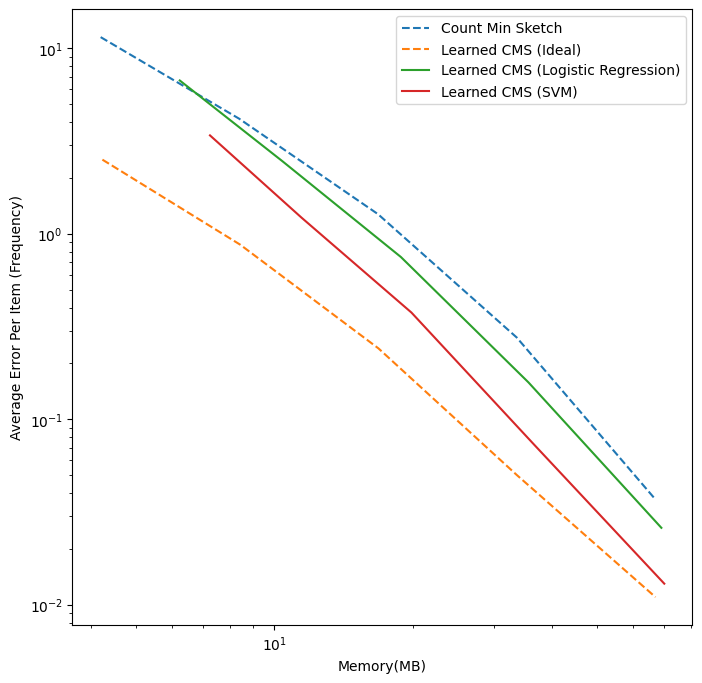

In [189]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.xscale("log")
plt.yscale("log")
for sketch_data in all_sketches.values():
    plt.plot(sketch_data["memory"], sketch_data["errors"], label = sketch_data["label"], linestyle = sketch_data["plot_linestyle"])
plt.xlabel("Memory(MB)")
plt.ylabel("Average Error Per Item (Frequency)")
plt.legend()
plt.show()